# Selection de cas debora pour tenter des trucs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import copy
import os, sys
from string import Template
import time
from IPython.display import display
import math

from trustutils import run 
from trustutils import visit
from trustutils.jupyter import plot

run.TRUST_parameters()

### TRUST parameters 
 * Version TRUST: 1.9.2_beta
 * Binary used: /volatile/catB/cr268029/triocfd/Multiphase/CMFD/CMFD_opt (built in directory /volatile/catB/cr268029/canal_bouillant/2023_02_void_drift/build)

In [3]:
# configurations de calcul

configs = [ "3eq",
            "4eq_vr0",
            "4eq_vrcst",
            "4eq_ishii",
            "4eq_forces",
            "6eq"
          ]
configs = [configs[i]+"_polymac" for i in range(6)] + [configs[i]+"_vdf" for i in range(6)]

labels = [ "3eq",
            "4eq vr0",
            "4eq vrcst",
            "4eq ishii",
            "4eq forces",
            "6eq"
          ]
labels = [labels[i]+" polymac" for i in range(6)] + [labels [i]+" vdf" for i in range(6)]

correlations_deriv = ["",
                      "Vitesse_relative derive_constante   { vg0_x 0 vg0_y 0 vg0_z 0 c0 1. }",
                      "Vitesse_relative derive_constante   { vg0_x 0 vg0_y 0 vg0_z 0.1 c0 1. }",
                      "	vitesse_relative derive_ishii { subcooled_boiling  0 }",
                      " frottement_interfacial bulles   { coeff_derive .5 rayon_bulle 1.e-3 } vitesse_relative derive_forces ",
                      " frottement_interfacial bulles   { coeff_derive .5 rayon_bulle 1.e-3 } "
                     ]
correlations_deriv*=2

sources_qdm = [""]*5 + [" frottement_interfacial { } , 	source_qdm Champ_Fonc_xyz dom 6 0 0 0 0 -9.81 -9.81 "]
sources_qdm *=2

alpha_res = [" alpha_res 1 alpha_res_min 0.5 "]*5 + [" alpha_res 1.e-5 alpha_res_min 5.e-6 "]
alpha_res*=2

polyedriser = ["polyedriser dom"]*6 + [""]*6
schema = ["polymac_p0  dis option_covimac {  }"]*6 + ["vdf  dis option_vdf {  traitement_coins oui traitement_gradients oui P_imposee_aux_faces oui }"]*6


In [4]:

n_seg_sonde = 1000

tab_name_sondes = ["alpha_gaz_sodium",
                   "vitesse_liquide_sodium",
                   "vitesse_gaz_sodium",
                   "temperature",
                   "masse_volumique",
                   "pression"
				   ]

str_sonde = " "
for name_sonde in tab_name_sondes:
    str_sonde += f" {name_sonde} {name_sonde} periode 1.e-2 segment {n_seg_sonde} 0.5 0.5 {5.e-4} 0.5 0.5 {1-5.e-4} \n"


In [5]:
#Create the calculation cases

force_recalculation = True 

n_raf = 1
title_raf = [1]


def GenerateInputFile(name,substitutions_dict):
    with open(f"build/jdd.data", "r") as file: 
        filedata = Template(file.read())
    result = filedata.substitute(substitutions_dict)
    with open(f"build/{name}.data", "w") as file:
        file.write(result)

if force_recalculation or not os.path.exists('build'):
    print('Recalculation running..')
    run.reset()
    run.defaultSuite_ = run.TRUSTSuite(runPrepare=False)

    for c in range(len(configs)) :
        print(f"Adding the launch files for {configs[c]}")
        if True :
            if True :
                folder_run = f"{configs[c]}"
                os.system(f'mkdir build/{folder_run}')
            
                if True :
                    name_run = f"{folder_run}"

                    substitutions_dict = {"correlations_deriv" : correlations_deriv[c] ,
                                          "sources_qdm": sources_qdm[c],                                  
                                          "sondes" : str_sonde ,
                                          "alpha_res" : alpha_res[c] ,
                                          "schema" : schema[c] ,
                                          "polyedriser" : polyedriser[c]
                                         }
                    GenerateInputFile(name_run,substitutions_dict)

                    os.system(f'mv build/{name_run}.data build/{folder_run}')
                    run.addCase(f"./{folder_run}", f"{name_run}.data")
    
    run.runCases()
    display(run.tablePerf())

else:
    print('No recalculation, reusing old results!')

No recalculation, reusing old results!


In [6]:
def loadText(data, index_column=0, nb_column=-1, transpose=True, dtype="float", skiprows=0):   
    if nb_column == -1:
        nb = None
    else:
        nb = index_column + nb_column
    try:
        if transpose:
            matrix = np.loadtxt(data, dtype=dtype, skiprows=skiprows).T[index_column:nb]
        else:
            matrix = np.loadtxt(data, dtype=dtype, skiprows=skiprows)[index_column:nb]
    except:
        matrix = np.loadtxt(data, dtype=dtype, skiprows=skiprows)                
    return matrix


In [24]:
def vitesse_relative_C0_dv0(alpha, vg, dv0, C0):
    return vg - ( vg - C0*vg*alpha - dv0  )/((1-alpha)*C0)

def vr_FI_Bulles(alpha, rhol, rhog, Rb, C_d) :
    vr0 = 0
    vr1 = 5

    while (vr1-vr0>1.e-4):
        vrmed = (vr0+vr1)/2

        fi = 1. / 8 * C_d * 3 * alpha * (1-alpha) / Rb * (alpha*rhog+(1-alpha)*rhol) * vrmed**2
        if fi < 9.81*alpha*(1-alpha)*(rhol-rhog):
            vr0 = vrmed
        else : 
            vr1 = vrmed

    return vr0

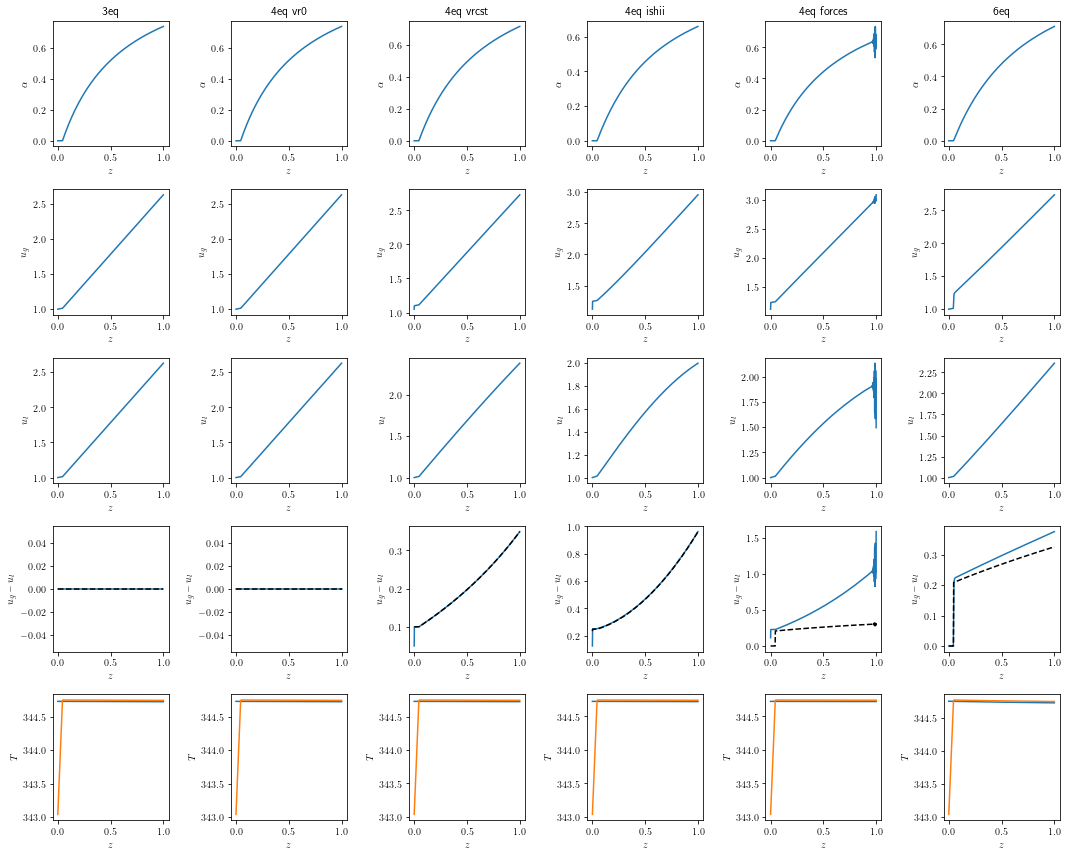

In [25]:
t_mesure = -1

fig = plt.figure(figsize = (15, 15))
axs = fig.subplots(6, 6)

for c in range(len(configs)) :
    folder_run = f"{configs[c]}"
    absc = np.linspace(5e-4, 1-5e-4, 1000)
    alphaSim  = np.array(loadText(f"build/{folder_run}/{folder_run}_ALPHA_GAZ_SODIUM.son"))[1::,t_mesure]
    vgSim     = np.array(loadText(f"build/{folder_run}/{folder_run}_VITESSE_GAZ_SODIUM.son"))[3::3,t_mesure]
    vlSim     = np.array(loadText(f"build/{folder_run}/{folder_run}_VITESSE_LIQUIDE_SODIUM.son"))[3::3,t_mesure]
    TgSim     = np.array(loadText(f"build/{folder_run}/{folder_run}_TEMPERATURE.son"))[2::2,t_mesure]
    TlSim     = np.array(loadText(f"build/{folder_run}/{folder_run}_TEMPERATURE.son"))[1::2,t_mesure]
    rhogSim   = np.array(loadText(f"build/{folder_run}/{folder_run}_MASSE_VOLUMIQUE.son"))[2::2,t_mesure]
    rholSim   = np.array(loadText(f"build/{folder_run}/{folder_run}_MASSE_VOLUMIQUE.son"))[1::2,t_mesure]
    PSim      = np.array(loadText(f"build/{folder_run}/{folder_run}_PRESSION.son"))[1::,t_mesure]

    axs[0+(c//6)*3,  c%6].plot(absc, alphaSim)
    axs[1+(c//6)*3,  c%6].plot(absc, vgSim-vlSim, label = "Simulation")
    axs[2+(c//6)*3,  c%6].plot(absc, PSim - PSim[-1], label = "Simulation")

    if (c%6==0) or (c%6==1) : 
        ur_th = np.linspace(0, 0, 1000)
    elif (c%6==2) : 
        ur_th = vitesse_relative_C0_dv0(alphaSim, vgSim, .1, 1)
    elif (c%6==3) : 
        C0_loc = 1.2 + (1.0 - 1.2) * (rhogSim / rholSim)**.5 
        sigma_sodium = 0.2405 * pow(1 - (TgSim+273.15) / 2503.7, 1.126)
        sigma_eau = 5.e-3
        dv0_loc = 2.**.5 * ( (rholSim- rhogSim) * 9.81 * sigma_sodium / rholSim / rholSim)**0.25 * (1.0 - alphaSim)**1.75
        ur_th = vitesse_relative_C0_dv0(alphaSim, vgSim, dv0_loc, C0_loc )

    elif (c%6==4) or (c%6==5) : 
        ur_th = [  vr_FI_Bulles(alphaSim[i], rholSim[i], rhogSim[i], 1.e-3, 0.5) for i in range(1000)]

    axs[1+(c//6)*3,  c%6].plot(absc, ur_th, 'k--', label = "Analytical")

    P_calc = np.linspace(PSim[-1], PSim[-1], 1000)
    for i in range(998, -1, -1) :
        P_calc[i] = P_calc[i+1] + 9.81*1.e-3*0.5*(alphaSim[i]*rhogSim[i]+alphaSim[i+1]*rhogSim[i+1]+(1-alphaSim[i])*rholSim[i]+(1-alphaSim[i+1])*rholSim[i+1])
    axs[2+(c//6)*3,  c%6].plot(absc, P_calc- P_calc[-1], 'k--', label = "Hydrosatic")
    if c==4 :
        PSim4 = PSim
    if c==5 :
        axs[2+(c//6)*3,  c%6].plot(absc, P_calc - P_calc[-1] + PSim4 - PSim4[-1], 'r--', label = "Hydrosatic + \n Pressure from 4eq")

    axs[1+(c//6)*3,  c%6].legend(fontsize = 6)
    axs[2+(c//6)*3,  c%6].legend(fontsize = 6)

    axs[0+(c//6)*3,  c%6].set_ylabel(r"$\alpha$")
    axs[1+(c//6)*3,  c%6].set_ylabel(r"$u_g-u_l$")
    axs[2+(c//6)*3,  c%6].set_ylabel(r"$P-P_{out}$")
    for i in range(3):
        axs[i+(c//6)*3,  c%6].set_xlabel(r"$z$")
        axs[i+(c//6)*3,  c%6].set_title(labels[c])


plt.tight_layout()
plt.savefig("Void_drift_1D.pdf")